# Normalize shapenet to lidar pcd

3514


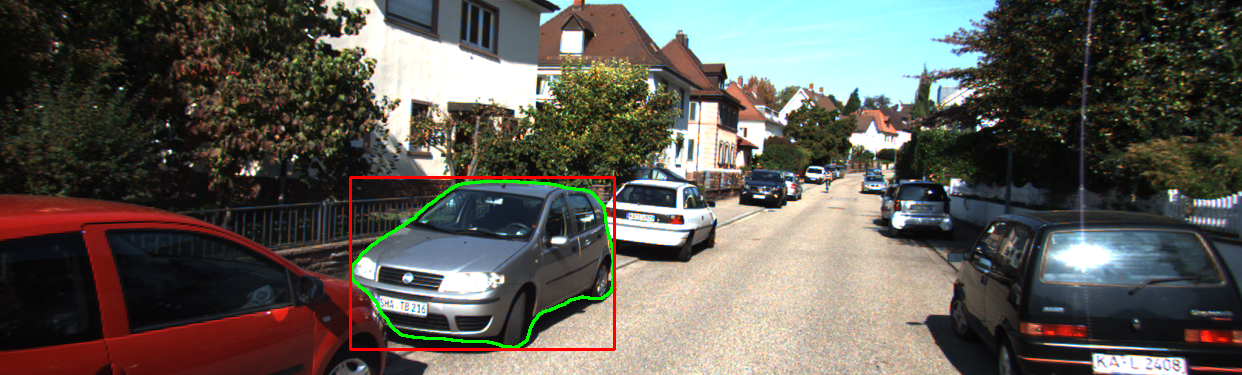

In [625]:
import csv
import numpy as np
import glob
import open3d as o3d
from PIL import Image

# Load shapenet
cat2id = {}
with open("/SEE-MTDA/data/shapenet/synsetoffset2category.txt", "r") as f:
    lines = csv.reader(f,delimiter='\t')
    for line in lines:
        cat2id[line[0]] = line[1]

cat = 'car'
objs = glob.glob(f'/SEE-MTDA/data/shapenet/ShapeNetCore.v2/{cat2id["car"]}/*/models/*.obj')
print(len(objs))

# Load raw lidar cars
data_dir = "/SEE-MTDA/data/kitti/exported/lidar_seg_data/points_in_bbox"
# data_dir = "/SEE-MTDA/data/nuscenes/v1.0-mini/exported/lidar_seg_data/points_in_bbox/CAM_BACK"
# data_dir = "/SEE-MTDA/data/nuscenes/custom_t4025-v3980/exported/lidar_seg_data/points_in_bbox/CAM_BACK"
# data_dir = "/SEE-MTDA/data/baraja/exported/lidar_seg_data/points_in_bbox"

seq_num = "000017"
raw_data = np.fromfile(f"{data_dir}/pointcloud/{seq_num}.bin", dtype=np.float32).reshape((-1,4))
gtlabel = np.fromfile(f"{data_dir}/labels/{seq_num}.label", dtype=np.uint32).reshape((-1,1))
mask = np.argwhere(gtlabel[:,0] == 10)[:,0]

bbox_raw = np.loadtxt(f"{data_dir}/gt_bboxes/{seq_num}.txt")
if np.count_nonzero(bbox_raw) != 0:
    boxpts = o3d.utility.Vector3dVector(bbox_raw)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    
img = Image.open(f"{data_dir}/image/{seq_num}.png")
img.show()

gtcenter = o3dbox.get_center()
lidarobj_dims = o3dbox.get_max_bound() - o3dbox.get_min_bound()

camera_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=np.array([0,0,0]))

lidarpcd = o3d.geometry.PointCloud()
lidarpcd.points = o3d.utility.Vector3dVector(raw_data[:,:3][mask])
lidarpcd.paint_uniform_color(np.array([1,0,0]))

# Normalize to shapenet
bbox=np.asarray(o3dbox.get_box_points())
yaw = np.arctan2(bbox[4, 1] - bbox[5, 1], bbox[4, 0] - bbox[5, 0])

rotation = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                            [np.sin(yaw), np.cos(yaw), 0],
                            [0, 0, 1]])


In [632]:
import point_cloud_utils as pcu

lidarpts = np.copy(raw_data[:,:3][mask])

v,f,n = pcu.load_mesh_vfn(objs[7])
v = v[:,[2,0,1]] # Change coordinates to be [x,y,z] instead of [z,x,y] which is the shapenet orientation (-z is forward)

# # normalize to unit length then scale to same size as car
# v = v / (np.max(v, axis=0) - np.min(v,axis=0))
# v[:,0] = v[:,0] * o3dbox.extent[0]
# v[:,1] = v[:,1] * o3dbox.extent[1]
# v[:,2] = v[:,2] * (o3dbox.extent[2]+0.2)  # manual offset for observation only

# # Apply real obj rot and center
# v = np.dot(v, rotation.T)
# v += (gtcenter + [0,0,-0.15]) # manual offset for observation only; real one will use random offsets

# dense random sampling
fi, bc = pcu.sample_mesh_random(v,f,300000)
v_sampled = pcu.interpolate_barycentric_coords(f, fi, bc, v)

shapenetpcd = o3d.geometry.PointCloud()
shapenetpcd.points = o3d.utility.Vector3dVector(v_sampled)
# shapenetpcd.paint_uniform_color(np.array([0,0,1]))

# Stats
shapenetobj_dims = np.linalg.norm(np.asarray(shapenetpcd.get_max_bound()) - np.asarray(shapenetpcd.get_min_bound()))
print(f'Center: {shapenetpcd.get_center()}')
print(f'o3dbox extent: {o3dbox.extent}')
o3d.visualization.draw_geometries([shapenetpcd])

Center: [ 0.01061063 -0.0006479   0.03900184]
o3dbox extent: [3.68 1.57 1.5 ]


In [627]:
camera = [0,0,0] 
radius = shapenetobj_dims*1000 # Between 800 and 1000 is good
_, pt_map = shapenetpcd.hidden_point_removal(camera, radius)
camvp = shapenetpcd.select_by_index(pt_map)

camera_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=camera)
o3d.visualization.draw_geometries([lidarpcd, camvp, camera_origin])

# Normalize lidar pcd to shapenet

3514


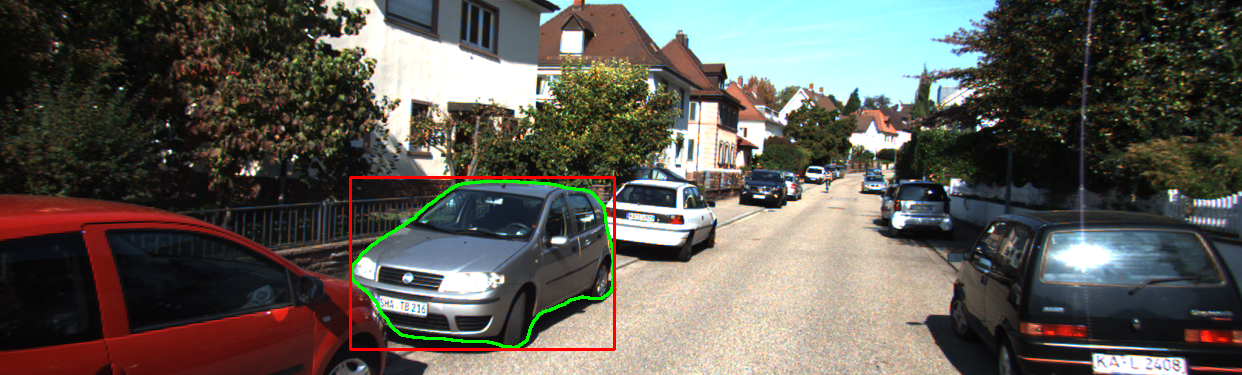

In [458]:
import csv
import numpy as np
import glob
import open3d as o3d
from PIL import Image

# Load shapenet
cat2id = {}
with open("/SEE-MTDA/data/shapenet/synsetoffset2category.txt", "r") as f:
    lines = csv.reader(f,delimiter='\t')
    for line in lines:
        cat2id[line[0]] = line[1]

cat = 'car'
objs = glob.glob(f'/SEE-MTDA/data/shapenet/ShapeNetCore.v2/{cat2id["car"]}/*/models/*.obj')
print(len(objs))

# Load raw lidar cars
data_dir = "/SEE-MTDA/data/kitti/exported/lidar_seg_data/points_in_bbox"
# data_dir = "/SEE-MTDA/data/nuscenes/v1.0-mini/exported/lidar_seg_data/points_in_bbox/CAM_BACK"
# data_dir = "/SEE-MTDA/data/nuscenes/custom_t4025-v3980/exported/lidar_seg_data/points_in_bbox/CAM_BACK"
# data_dir = "/SEE-MTDA/data/baraja/exported/lidar_seg_data/points_in_bbox"

seq_num = "000017"
raw_data = np.fromfile(f"{data_dir}/pointcloud/{seq_num}.bin", dtype=np.float32).reshape((-1,4))
gtlabel = np.fromfile(f"{data_dir}/labels/{seq_num}.label", dtype=np.uint32).reshape((-1,1))
mask = np.argwhere(gtlabel[:,0] == 10)[:,0]

bbox_raw = np.loadtxt(f"{data_dir}/gt_bboxes/{seq_num}.txt")
if np.count_nonzero(bbox_raw) != 0:
    boxpts = o3d.utility.Vector3dVector(bbox_raw)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    
img = Image.open(f"{data_dir}/image/{seq_num}.png")
img.show()

gtcenter = o3dbox.get_center()
lidarobj_dims = o3dbox.get_max_bound() - o3dbox.get_min_bound()

camera_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=np.array([0,0,0]))

lidarpcd = o3d.geometry.PointCloud()
lidarpcd.points = o3d.utility.Vector3dVector(raw_data[:,:3][mask])

# Normalize to shapenet
bbox=np.asarray(o3dbox.get_box_points())
yaw = np.arctan2(bbox[4, 1] - bbox[5, 1], bbox[4, 0] - bbox[5, 0])

rotation = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                            [np.sin(yaw), np.cos(yaw), 0],
                            [0, 0, 1]])

# Get normalized bbox
bbox = bbox - o3dbox.get_center()
bbox = np.dot(bbox, rotation)
bbox = bbox / o3dbox.extent[0]
bbox = bbox + o3dbox.get_center()
rotbbox = o3d.utility.Vector3dVector(bbox)
roto3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(rotbbox)
roto3dbox.color = np.array([1,0,1])

# Get normalized pcd
raw_pts_norm = raw_data[:,:3] - o3dbox.get_center()
raw_pts_norm = np.dot(raw_pts_norm, rotation)
raw_pts_norm = raw_pts_norm / np.linalg.norm(lidarobj_dims)
raw_pts_norm = raw_pts_norm[mask]
lidarpcdnorm = o3d.geometry.PointCloud()
lidarpcdnorm.points = o3d.utility.Vector3dVector(raw_pts_norm)

# o3d.visualization.draw_geometries([lidarpcd, lidarpcdnorm, camera_origin, o3dbox, roto3dbox])

In [464]:
import point_cloud_utils as pcu

lidarpts_norm = np.copy(raw_pts_norm)

v,f,n = pcu.load_mesh_vfn(objs[6])
v = v[:,[2,0,1]] # Change coordinates to be [x,y,z] instead of [z,x,y] which is the shapenet orientation (-z is forward)
# # Add random translation and rotation
tmat = [[1,-1][np.random.randint(2)]*np.random.rand()*10, 
     [1,-1][np.random.randint(2)]*np.random.rand()*10, 
     [1,-1][np.random.randint(2)]*np.random.rand()*0.5 - 1.8]
v += tmat
lidarpts_norm += tmat 
lidarpts_norm += [0,0.5,0]

# dense random sampling
fi, bc = pcu.sample_mesh_random(v,f,300000)
v_sampled = pcu.interpolate_barycentric_coords(f, fi, bc, v)

shapenetpcd = o3d.geometry.PointCloud()
shapenetpcd.points = o3d.utility.Vector3dVector(v_sampled)
# shapenetpcd.paint_uniform_color(np.array([1,0,1]))

lidarnormpcd = o3d.geometry.PointCloud()
lidarnormpcd.points = o3d.utility.Vector3dVector(lidarpts_norm)
lidarnormpcd.paint_uniform_color(np.array([1,0,0]))

# # Random car length scaling
# shapenetpcd.scale(np.random.uniform(3,5), center=shapenetpcd.get_center())

# Stats
obj_dims = np.linalg.norm(np.asarray(shapenetpcd.get_max_bound()) - np.asarray(shapenetpcd.get_min_bound()))
print(f'Dimensions: {obj_dims}')
print(f'Center: {shapenetpcd.get_center()}')

o3d.visualization.draw_geometries([shapenetpcd,lidarnormpcd])

Dimensions: 0.9994251908730385
Center: [ 8.92503671 -5.96580147 -1.53832436]


In [467]:
camera = [0,0,0] 
radius = obj_dims*1000 # Between 800 and 1000 is good
_, pt_map = shapenetpcd.hidden_point_removal(camera, radius)
camvp = shapenetpcd.select_by_index(pt_map)

camera_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=camera)
o3d.visualization.draw_geometries([camvp, camera_origin])

In [202]:
radii, camvp_pts = [], []
for i in np.logspace(1,3,num=50):
    
    _, pt_map = pcd.hidden_point_removal(camera, obj_dims*i)
    radii.append(obj_dims*i)
    camvp_pts.append(len(pt_map))

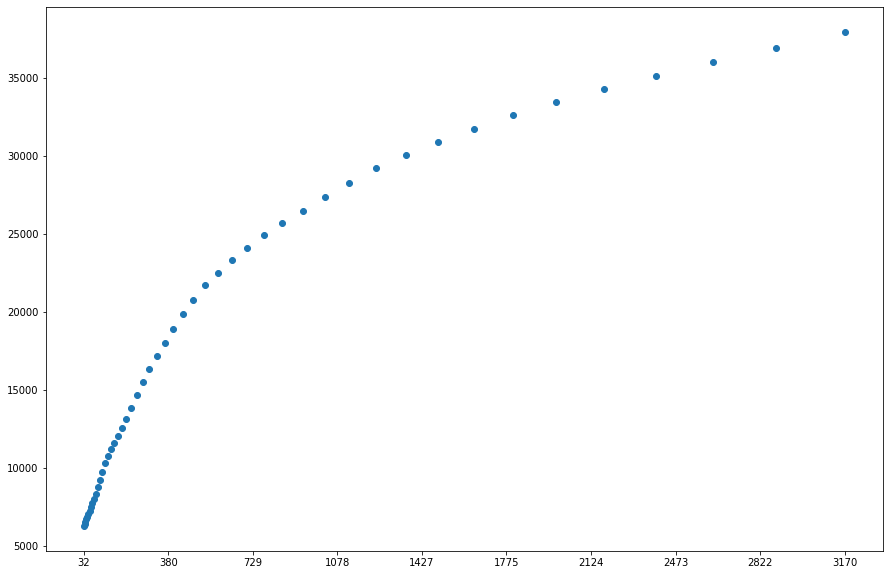

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(radii, camvp_pts)
plt.xticks(np.linspace(min(radii),max(radii), 10))
plt.show()

In [16]:
mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(v),o3d.utility.Vector3iVector(f))
surface_pts = mesh.sample_points_uniformly(100000)
o3d.visualization.draw_geometries([surface_pts])

In [44]:
import time

runtime = []
num_pts = []
for npts in np.linspace(0,1000000,1000):
    t0 = time.time()
    fi, bc = pcu.sample_mesh_random(v,f,int(npts))
    v_sampled = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    runtime.append(time.time()-t0)
    num_pts.append(npts)

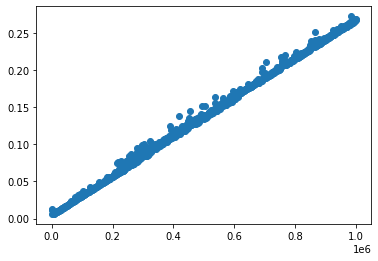

In [45]:
import matplotlib.pyplot as plt

plt.scatter(num_pts, runtime)
plt.xlabel

In [47]:
0.2*10e6

2000000.0